### What does this code do:
This code processes the atmmodel.csv from C-code and returns a clean (???) training dataset w/the <same_name_preprocessed.csv> label at the end.

it performs the following tasks on the oroginal training dataset:
- rm outliers from atm data

In [1]:
import os
import pandas as pd
# import matplotlib.pyplot as plt 

In [2]:
from datetime import datetime
today = datetime.today()

print('latest run on:', today)

latest run on: 2022-09-06 14:12:54.329275


In [3]:
remove_camera_outlier = False 

### functions(.)

In [4]:
def remove_outliers_IQR(df, cutoff):
    
    df.drop((df[df['rms'] > cutoff].index), inplace=True)
    
    print('Removing outliers in ATM roughness values (IQR method): after dropping roughness values > %.1f in dataset; new shape= (%s,%s)' %(cutoff, df.shape[0], df.shape[1]))
    return  # the same as None, cuz inplace=True


In [5]:
def cutoff_rms_zeroTo10(df):
    
    df.drop((df[df['rms'] > 10].index), inplace=True)
    
    print('Removing ATM roughness values > 10cm; new shape= (%s,%s)' %(df.shape[0], df.shape[1]))
    return  # the same as None, cuz inplace=True

In [6]:
def cutoff_rms_10To20(df):
    
    df.drop((df[df['rms'] < 10].index), inplace=True)
    df.drop((df[df['rms'] > 20].index), inplace=True)
        
    print('Removing ATM roughness values not in 10 > rms > 20cm; new shape= (%s,%s)' %(df.shape[0], df.shape[1]))
    return  # the same as None, cuz inplace=True

In [7]:
def cutoff_rms_20To30(df):
    
    df.drop((df[df['rms'] < 20].index), inplace=True)
    df.drop((df[df['rms'] > 30].index), inplace=True)

    print('Removing ATM roughness values not in 20 > rms > 30cm; new shape= (%s,%s)' %(df.shape[0], df.shape[1]))
    return  # the same as None, cuz inplace=True

## input directory

In [8]:
dataset_dir = "/Users/ehsanmos/MLP_dataset/atmmodels"

In [9]:
if os.path.isdir(dataset_dir) == False:
    print("dataset directory NOT found!")
else:
    print("dataset directory FOUND!")

dataset directory FOUND!


## Load input/ training dataset

before doing this section, process filter final input dataset with "check_n_filter_final_dataset"

In [10]:
# in_ds = "atmmodel_april_2016_k_zero_9cams4bands_original.csv"

in_ds = "atmmodel_july_2016_k_zero_9cams4bands_original.csv"

## check if input dataset file exists

In [11]:
in_ds_fullpath = os.path.join(dataset_dir, in_ds)
print(in_ds_fullpath)

if (not os.path.isfile(os.path.join(in_ds_fullpath))):
    raise SystemExit()
else:
    print("input dataset FOUND!")

/Users/ehsanmos/MLP_dataset/atmmodels/atmmodel_july_2016_k_zero_9cams4bands_original.csv
input dataset FOUND!


## Read in dataset and look at dataset columns

In [12]:
df_orig = pd.read_csv(in_ds_fullpath, engine='python')

In [13]:
df_orig.shape

(34403, 24)

In [14]:
df_orig.columns

Index(['path', 'orbit', 'img_block', 'line', 'sample', 'firstLat', 'firstLon',
       'anr', 'ang', 'anb', 'annir', 'aa', 'af', 'ba', 'bf', 'ca', 'cf', 'da',
       'df', 'rms', 'weight', 'npts', 'cloud', 'var'],
      dtype='object')

## drop redundant columns
why drop columns? because we do not use them in training our neural nets

In [15]:
##- with 12 cameras
dataset_df = df_orig.drop(['path', 'orbit', 'img_block', 'line', 'sample', 'weight', 'npts', 'cloud', 'var'], axis=1)

print('new columns:')
print(len(dataset_df.columns)) # columns should be only 12 cameras + rms + latlon
print(dataset_df.columns)


new columns:
15
Index(['firstLat', 'firstLon', 'anr', 'ang', 'anb', 'annir', 'aa', 'af', 'ba',
       'bf', 'ca', 'cf', 'da', 'df', 'rms'],
      dtype='object')


### Visual check of dataset before cleaning data
look at stats of some columns

In [16]:
print('AN, before cleaning bad data:')
print('min: %s' % dataset_df['anr'].min())
print('max: %s' % dataset_df['anr'].max())
print('mean: %s' %dataset_df['anr'].mean())
print('median: %s' %dataset_df['anr'].median())


print('\nATM roughness, before cleaning bad data:')
print('min: %s' % dataset_df['rms'].min())
print('max: %s' % dataset_df['rms'].max())
print('mean: %s' %dataset_df['rms'].mean())
print('median: %s' %dataset_df['rms'].median())

AN, before cleaning bad data:
min: -1.0
max: 1.87117
mean: 0.07000946516292185
median: 0.391959

ATM roughness, before cleaning bad data:
min: 2.3375
max: 148.8825
mean: 8.525203821614394
median: 5.903333


### plot histogram of all columns of input dataset to visually check distribution of data 

array([[<AxesSubplot:title={'center':'firstLat'}>,
        <AxesSubplot:title={'center':'firstLon'}>,
        <AxesSubplot:title={'center':'anr'}>,
        <AxesSubplot:title={'center':'ang'}>],
       [<AxesSubplot:title={'center':'anb'}>,
        <AxesSubplot:title={'center':'annir'}>,
        <AxesSubplot:title={'center':'aa'}>,
        <AxesSubplot:title={'center':'af'}>],
       [<AxesSubplot:title={'center':'ba'}>,
        <AxesSubplot:title={'center':'bf'}>,
        <AxesSubplot:title={'center':'ca'}>,
        <AxesSubplot:title={'center':'cf'}>],
       [<AxesSubplot:title={'center':'da'}>,
        <AxesSubplot:title={'center':'df'}>,
        <AxesSubplot:title={'center':'rms'}>, <AxesSubplot:>]],
      dtype=object)

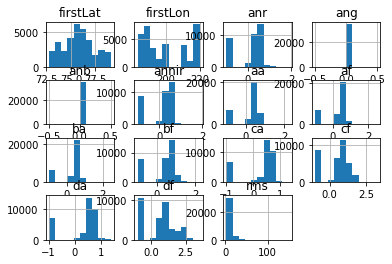

In [17]:
dataset_df.hist(bins=10)

## remove negative data from each row
we want to train our MLP models, so we will remove negative values, NAN values, masked values such as land mask, etc. also any rows that does not have all 9 or 12 cameras all together

In [18]:
print('before dropping negative values: (%s, %s)' %dataset_df.shape)


#- remove/ drop negative values from all input features
dataset_df.drop((dataset_df[dataset_df['da'] < 0.0].index) | 
                (dataset_df[dataset_df['ca'] < 0.0].index) | 
                (dataset_df[dataset_df['ba'] < 0.0].index) |
                (dataset_df[dataset_df['aa'] < 0.0].index) |
                (dataset_df[dataset_df['anr'] < 0.0].index) |
                (dataset_df[dataset_df['ang'] < 0.0].index) |
                (dataset_df[dataset_df['anb'] < 0.0].index) |
                (dataset_df[dataset_df['annir'] < 0.0].index) |
                (dataset_df[dataset_df['af'] < 0.0].index) |
                (dataset_df[dataset_df['bf'] < 0.0].index) |
                (dataset_df[dataset_df['cf'] < 0.0].index) |
                (dataset_df[dataset_df['df'] < 0.0].index), inplace=True)


print('after dropping negative values: (%s, %s)' %dataset_df.shape)

before dropping negative values: (34403, 15)
after dropping negative values: (17693, 15)


/var/folders/cg/r5rsmy1146d38c9kj97z_55w0000gn/T/ipykernel_35878/3998210268.py:5: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead.
  dataset_df.drop((dataset_df[dataset_df['da'] < 0.0].index) |


## remove outlier values from camera/ manually

In [19]:
cam_outlier = 2.0


if (remove_camera_outlier == True):
    print("removing camera outliers")
    dataset_df.drop(dataset_df[(dataset_df['Da_r'] > cam_outlier) |
                               (dataset_df['Ca_r'] > cam_outlier) |
                               (dataset_df['Ba_r'] > cam_outlier) |
                               (dataset_df['Aa_r'] > cam_outlier) |
                               (dataset_df['An_r'] > cam_outlier) |
                               (dataset_df['Af_r'] > cam_outlier) |
                               (dataset_df['Bf_r'] > cam_outlier) |
                               (dataset_df['Cf_r'] > cam_outlier) |
                               (dataset_df['Df_r'] > cam_outlier)].index, inplace=True)

else:
    print('we did NOT remove camera outliers manually!')

we did NOT remove camera outliers manually!


## remove outlier values from ATM roughness data/ percentile

In [20]:
#- identify outliers in ATM roughnes values with interquartile range (IQRange)
from numpy import percentile

#- extract data 
data = dataset_df.loc[:,'rms']
print(type(data))
#- calculate InterQuartile Range == IQR
q25, q75 = percentile(data, 25), percentile(data, 75)
iqr = q75 - q25
print('Percentiles: 25th= %.3f (cm), 75th= %.3f (cm), InterQuartile Range= %.3f (cm)' % (q25, q75, iqr))
#- calculate the outlier cutoff
cut_off = iqr * 3
lower, upper = q25 - cut_off, q75 + cut_off
print('lower cutoff= %.1f, upper cutoff= %.1f' % (lower, upper))
#- identify outliers
outliers = [x for x in data if x > upper] # list comprehension method
print('Identified outliers: %d \n' % len(outliers))


'''remove outliers
'''
remove_outliers_IQR(dataset_df, upper)

<class 'pandas.core.series.Series'>
Percentiles: 25th= 4.315 (cm), 75th= 10.182 (cm), InterQuartile Range= 5.867 (cm)
lower cutoff= -13.3, upper cutoff= 27.8
Identified outliers: 449 

Removing outliers in ATM roughness values (IQR method): after dropping roughness values > 27.8 in dataset; new shape= (17244,15)


## >>> Select RMS data for range of smooth analysis 

In [21]:
'''select RMS data for smooth analysis
'''
cutoff_rms_zeroTo10(dataset_df)

# cutoff_rms_10To20(dataset_df)

# cutoff_rms_20To30(dataset_df)

Removing ATM roughness values > 10cm; new shape= (13140,15)


## check for any NAN values

In [22]:
#~ check all columns all together

if (dataset_df['da'].isnull().values.any() | 
    dataset_df['ca'].isnull().values.any() | 
    dataset_df['ba'].isnull().values.any() |
    dataset_df['aa'].isnull().values.any() |
    dataset_df['anr'].isnull().values.any() |
    dataset_df['ang'].isnull().values.any() |
    dataset_df['anb'].isnull().values.any() |
    dataset_df['annir'].isnull().values.any() |
    dataset_df['af'].isnull().values.any() |
    dataset_df['bf'].isnull().values.any() |
    dataset_df['cf'].isnull().values.any() |
    dataset_df['df'].isnull().values.any()):
    
    print('found NAN in one DF column')

else:
    print('did NOT find any NAN value in any column\n')


did NOT find any NAN value in any column



## check for any negative value
values() function comes from numpy and is faster

In [23]:
#- double check for any negative values in all columns
if ((dataset_df.values < 0).any()):
    print('found some negative values in DF! something is wrong!')
else:
    print('double check: NO negative values found anywhere in DF')

double check: NO negative values found anywhere in DF


## histogram of dataset
defining histogram bins and checking the hostogram of input data again after cleaning dataset

array([[<AxesSubplot:title={'center':'firstLat'}>,
        <AxesSubplot:title={'center':'firstLon'}>,
        <AxesSubplot:title={'center':'anr'}>,
        <AxesSubplot:title={'center':'ang'}>],
       [<AxesSubplot:title={'center':'anb'}>,
        <AxesSubplot:title={'center':'annir'}>,
        <AxesSubplot:title={'center':'aa'}>,
        <AxesSubplot:title={'center':'af'}>],
       [<AxesSubplot:title={'center':'ba'}>,
        <AxesSubplot:title={'center':'bf'}>,
        <AxesSubplot:title={'center':'ca'}>,
        <AxesSubplot:title={'center':'cf'}>],
       [<AxesSubplot:title={'center':'da'}>,
        <AxesSubplot:title={'center':'df'}>,
        <AxesSubplot:title={'center':'rms'}>, <AxesSubplot:>]],
      dtype=object)

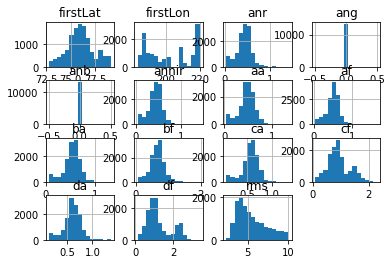

In [24]:
dataset_df.hist(bins=15)

In [25]:
dataset_df.describe()

,firstLat,firstLon,anr,ang,anb,annir,aa,af,ba,bf,ca,cf,da,df,rms
count,13140.000000,13140.000000,13140.000000,13140.0,13140.0,13140.000000,13140.000000,13140.000000,13140.000000,13140.000000,13140.000000,13140.000000,13140.000000,13140.000000,13140.000000
mean,75.994299,201.633608,0.430833,0.0,0.0,0.430833,0.475433,0.503994,0.531416,0.667600,0.565446,0.927526,0.602632,1.229067,5.466192
std,1.374762,13.486032,0.163820,0.0,0.0,0.163820,0.170161,0.177635,0.176110,0.229460,0.173156,0.393541,0.176415,0.636102,1.795318
min,72.764586,183.216254,0.034088,0.0,0.0,0.034088,0.044036,0.040465,0.060695,0.056706,0.085252,0.077717,0.123204,0.128087,2.348333
25%,75.138279,188.070124,0.352616,0.0,0.0,0.352616,0.395802,0.415469,0.456592,0.536831,0.492595,0.664668,0.523207,0.799175,4.016667
50%,75.938904,199.430414,0.441738,0.0,0.0,0.441738,0.485079,0.518470,0.550228,0.681348,0.582718,0.871572,0.610291,1.053856,5.004167
75%,76.774986,216.903294,0.531530,0.0,0.0,0.531530,0.583065,0.605233,0.634180,0.795859,0.666316,1.115580,0.708027,1.530957,6.650000
max,79.073270,220.001111,1.413194,0.0,0.0,1.413194,1.333279,1.663056,1.310579,1.970470,1.323347,2.314382,1.370876,3.365002,10.000000


## write out output csv

In [26]:
output_dir = dataset_dir

out_label = 'cleanready4NN_rms_zeroTo10'
# out_label = 'cleanready4NN_rms_10To20'
# out_label = 'cleanready4NN_rms_20To30'



output_filename = in_ds.split('.')[0]+'_'+out_label+'.csv'

output_csv_fullpath = os.path.join(output_dir, output_filename)
print('output csv file:')
output_csv_fullpath

output csv file:


'/Users/ehsanmos/MLP_dataset/atmmodels/atmmodel_july_2016_k_zero_9cams4bands_original_cleanready4NN_rms_zeroTo10.csv'

In [27]:
dataset_df.to_csv(output_csv_fullpath, index=False)